<a href="https://colab.research.google.com/github/AmirGhnbr/philnet/blob/main/philnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download the data from kaggle

### you need to sign in to kaggle and download kaggle.json formatted api key to being able to access the dataset

upload the kaggle.json api key to colab

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!pip install -q kaggle

In [ ]:
!pwd

/content


In [ ]:
!rm -r ~/.kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!pwd

/content


In [ ]:
# %cd ./kaggle
!kaggle datasets download -d yogesh94/m4-forecasting-competition-dataset

m4-forecasting-competition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 Daily-test.csv     kaggle				     Monthly-test.csv	   Weekly-test.csv
 Daily-train.csv   'kaggle (1).json'			     Monthly-train.csv	   Weekly-train.csv
 drive		    kaggle.json				     Quarterly-test.csv    Yearly-test.csv
 Hourly-test.csv    m4-forecasting-competition-dataset.zip   Quarterly-train.csv   Yearly-train.csv
 Hourly-train.csv   m4_info.csv				     sample_data


In [ ]:
!cp m4-forecasting-competition-dataset.zip ./kaggle

In [ ]:
!unzip m4-forecasting-competition-dataset.zip

Archive:  m4-forecasting-competition-dataset.zip
replace Daily-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import all the necessary libraries and prepare the dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import LSTM, Input,add, Dense
from keras.layers import Input, Dense, Dropout, TimeDistributed,LSTM, Concatenate, MultiHeadAttention

In [ ]:
info_csv = pd.read_csv('m4_info.csv')
info_csv

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00
...,...,...,...,...,...,...
99995,H410,Other,24,48,Hourly,01-01-17 12:00
99996,H411,Other,24,48,Hourly,01-01-17 12:00
99997,H412,Other,24,48,Hourly,01-01-17 12:00
99998,H413,Other,24,48,Hourly,12-06-17 12:00


In [ ]:
daily_info = info_csv[info_csv['SP']=='Daily']
daily_info.head(20)

,M4id,category,Frequency,Horizon,SP,StartingDate
95359,D1,Macro,1,14,Daily,03-01-94 12:00
95360,D2,Macro,1,14,Daily,02-01-95 12:00
95361,D3,Macro,1,14,Daily,05-01-06 12:00
95362,D4,Macro,1,14,Daily,30-05-96 12:00
95363,D5,Macro,1,14,Daily,03-01-97 12:00
95364,D6,Macro,1,14,Daily,03-01-97 12:00
95365,D7,Macro,1,14,Daily,03-01-97 12:00
95366,D8,Macro,1,14,Daily,20-03-13 12:00
95367,D9,Macro,1,14,Daily,20-03-13 12:00
95368,D10,Macro,1,14,Daily,03-07-14 12:00


In [ ]:
daily_info[daily_info['category']=='Finance']

,M4id,category,Frequency,Horizon,SP,StartingDate
97394,D2036,Finance,1,14,Daily,01-04-05 12:00
97395,D2037,Finance,1,14,Daily,04-01-99 12:00
97396,D2038,Finance,1,14,Daily,16-05-03 12:00
97397,D2039,Finance,1,14,Daily,19-04-00 12:00
97398,D2040,Finance,1,14,Daily,21-05-13 12:00
...,...,...,...,...,...,...
98948,D3590,Finance,1,14,Daily,30-03-01 12:00
98949,D3591,Finance,1,14,Daily,30-03-01 12:00
98950,D3592,Finance,1,14,Daily,30-03-01 12:00
98951,D3593,Finance,1,14,Daily,30-03-01 12:00


In [ ]:
daily = pd.read_csv('Daily-train.csv')

In [ ]:
daily.describe()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V9911,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920
count,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,...,1.0,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.00,1.0
mean,3847.763728,3686.945638,3659.987132,3658.522032,3673.968742,3666.804494,3670.476838,3685.930165,3688.808034,3692.429740,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
std,6946.099377,3048.133629,3015.707133,3011.115215,3031.807762,3016.486609,3020.937907,3034.598425,3036.281002,3042.386898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
25%,1257.700000,1264.510000,1260.515000,1264.900000,1268.499856,1263.980000,1267.410000,1272.155000,1277.850000,1280.156250,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
50%,2612.000000,2629.922522,2611.250000,2600.000000,2598.700417,2600.880000,2609.200000,2611.960000,2617.970000,2626.800000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
75%,5451.000000,5412.807912,5401.765000,5377.889080,5430.700000,5423.950000,5401.050000,5447.500000,5469.650000,5483.600000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0
max,352000.000000,26947.600000,27159.200000,26024.700000,25953.900000,25691.100000,25634.300000,25584.800000,25578.100000,25605.900000,...,926.0,919.25,928.75,915.25,920.75,924.0,945.5,942.0,948.75,947.0


In [ ]:
import random

random_number = random.randint(2036, 3594)
random_number

2333

In [ ]:
values = daily.loc[random_number].dropna().values[1:]

In [ ]:
dataset = pd.DataFrame({'num': range(1, len(values) + 1), 'value': values}).dropna().set_index('num')
dataset

,value
num,
1,2529.6
2,2486.9
3,2508.0
4,2482.6
5,2429.6
...,...
3566,13511.1
3567,13435.3
3568,13436.6


In [ ]:
scaler = MinMaxScaler()

# fit the scaler to the data and transform the data
normalized = scaler.fit_transform(dataset).squeeze()
normalized

array([0.02462441, 0.02123915, 0.02291196, ..., 0.88933286, 0.87910572,
       0.88736671])

In [ ]:
normalized_dataset = pd.DataFrame({'num': range(1, len(normalized) + 1), 'value': normalized}).dropna().set_index('num')
normalized_dataset

,value
num,
1,0.024624
2,0.021239
3,0.022912
4,0.020898
5,0.016696
...,...
3566,0.895239
3567,0.889230
3568,0.889333


In [ ]:
normalized_dataset.mean()

value    0.417902
dtype: float64

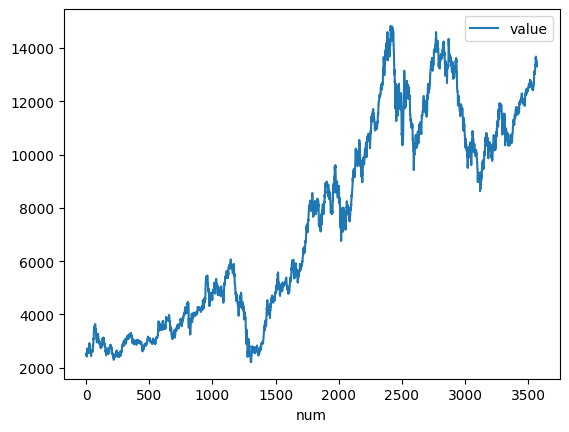

In [ ]:
dataset.plot();

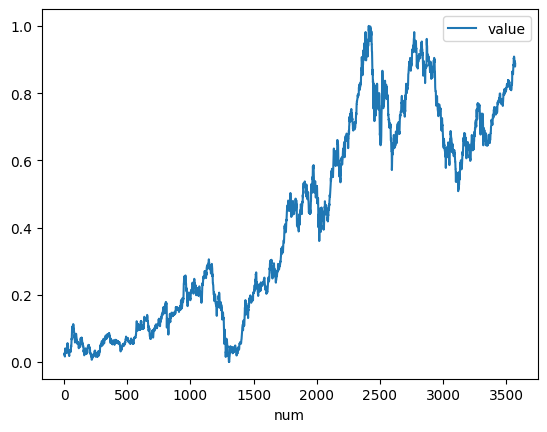

In [ ]:
normalized_dataset.plot();

#windowing the dataset and prepare it to the model

In [ ]:
HORIZON = 18 #12
WINDOW_SIZE = 36 #48
BATCH_SIZE = 64

In [ ]:
def create_data_window(dataframe):
  X = dataframe.copy()

  windows = pd.DataFrame(columns=[f'window_{i}' for i in range(WINDOW_SIZE)])
  labels = pd.DataFrame(columns=[f'label_{i}' for i in range(HORIZON)])

  # loop through the time series data and create windows and labels
  for i in range(0, len(X) - WINDOW_SIZE - HORIZON + 1, WINDOW_SIZE):
      window = X.iloc[i:i+WINDOW_SIZE]['value'].values
      label = X.iloc[i+WINDOW_SIZE:i+WINDOW_SIZE+HORIZON]['value'].values
      windows.loc[X.index[i+WINDOW_SIZE+HORIZON-1]] = window
      labels.loc[X.index[i+WINDOW_SIZE+HORIZON-1]] = label

  # convert windows and labels back to DataFrames
  windows = pd.DataFrame(windows, columns=[f'window_{i}' for i in range(WINDOW_SIZE)], index=windows.index)
  labels = pd.DataFrame(labels, columns=[f'label_{i}' for i in range(HORIZON)], index=labels.index)
  return windows,labels

In [ ]:
create_data_window(normalized_dataset)

(      window_0  window_1  window_2  window_3  window_4  window_5  window_6  \
 54    0.024624  0.021239  0.022912  0.020898  0.016696  0.016086  0.024101   
 90    0.024767  0.020787  0.019257  0.019630  0.018163  0.032497  0.032973   
 126   0.110738  0.108582  0.094986  0.099148  0.093122  0.091933  0.088643   
 162   0.058326  0.059040  0.057486  0.053839  0.054093  0.048266  0.041963   
 198   0.056693  0.054870  0.047933  0.046387  0.046609  0.047782  0.048543   
 ...        ...       ...       ...       ...       ...       ...       ...   
 3402  0.644524  0.650034  0.650042  0.644397  0.652357  0.657137  0.654624   
 3438  0.720989  0.710580  0.711460  0.711809  0.705014  0.706457  0.712942   
 3474  0.745241  0.746208  0.744781  0.742601  0.740302  0.741016  0.743806   
 3510  0.771499  0.776549  0.767947  0.772157  0.772157  0.774607  0.776612   
 3546  0.813216  0.804305  0.811408  0.814017  0.809315  0.810140  0.809157   
 
       window_7  window_8  window_9  ...  window_2

In [ ]:
def create_full_datset(windowed_X, windowed_y, batch_size=64):
  # drop_list = ['value' if i==0 else f"value-{i}" for i in range(HORIZON)]
  # X = windowed_dataset.dropna().drop(drop_list, axis=1)
  # y = windowed_dataset.dropna()[drop_list]

  split_size = int(len(windowed_X) * 0.8)
  X_train, y_train = windowed_X[:split_size], windowed_y[:split_size]
  X_test, y_test = windowed_X[split_size:], windowed_y[split_size:]

  X_train = X_train.astype('float32')
  y_train = y_train.astype('float32')
  X_test = X_test.astype('float32')
  y_test = y_test.astype('float32')

  train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

  # 2. Combine features & labels
  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  # 3. Batch and prefetch for optimal performance
  BATCH_SIZE = batch_size # taken from Appendix D in N-BEATS paper
  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

# Pilnet Architecture Details

* I have used m4 dataset

* number of hidden neurons in feedforward of each level is 64

* number of layers in feedforward of each level is 2

* window size 54

* horizon 18

* number of levels for m4 dataset is 8



In [ ]:
class MovingAverageSmoothingLayer(tf.keras.layers.Layer):
    def __init__(self, pool_size=3, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.average_pooling_layer = tf.keras.layers.AveragePooling1D(pool_size=(self.pool_size))

    def call(self, inputs):
        inputs = tf.reshape(inputs, shape=(-1, 36, 1))
        return self.average_pooling_layer(inputs)


In [ ]:
INPUT_SIZE = WINDOW_SIZE

In [ ]:
class WAPE(Metric):
    def __init__(self, name='wape', **kwargs):
        super(WAPE, self).__init__(name=name, **kwargs)
        self.total_abs_error = self.add_weight(name='total_abs_error', initializer='zeros')
        self.total_demand = self.add_weight(name='total_demand', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        abs_error = tf.abs(y_true - y_pred)
        demand = tf.reduce_sum(y_true)
        self.total_abs_error.assign_add(tf.reduce_sum(abs_error))
        self.total_demand.assign_add(demand)

    def result(self):
        return self.total_abs_error / self.total_demand * 100


In [ ]:
def philnet_level(input_layer,sigma,prev_hidden_state,is_first_level=False):

  # Moving Average Smoothing
  smoothed_input = MovingAverageSmoothingLayer(sigma)(input_layer)
  # Create the LSTM layer
  # lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation=tf.keras.layers.LeakyReLU(alpha=0.001),return_sequences=True,return_state=True))(smoothed_input)
  lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation=tf.keras.layers.LeakyReLU(alpha=0.001), return_sequences=True))(smoothed_input)
  attention = MultiHeadAttention(num_heads=7, key_dim=7)(lstm1, lstm1)
  concat = Concatenate()([lstm1, attention])
  lstm, forward_h, backward_h = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation=tf.keras.layers.LeakyReLU(alpha=0.001), return_sequences=True,return_state=True))(concat)

  state_h = Concatenate()([forward_h, backward_h])
  # state_h = add([forward_h, backward_h])
  # lstm_layer, state_h, state_c = LSTM(units=128, return_state=True)(smoothed_input)

  if is_first_level:
    summed_state_h = state_h
  else:
    summed_state_h = add([state_h, prev_hidden_state])

  # as illustrated in table 5 for m4 dataset:
  # uses 2 layers with 64 units and 8 levels
  dense_layer1 = Dense(units=128, activation=tf.keras.layers.LeakyReLU(alpha=0.001))(summed_state_h)
  # drop_1 = Dropout(0.1)(dense_layer1)
  dense_layer2 = Dense(units=128, activation=tf.keras.layers.LeakyReLU(alpha=0.001))(dense_layer1)
  # drop_2 = Dropout(0.1)(dense_layer2)
  # dropout_1 = tf.keras.layers.Dropout(0.1)(dense_layer1)
  dense_layer3 = Dense(units=128, activation=tf.keras.layers.LeakyReLU(alpha=0.001))(dense_layer2)

  # dropout_2 = tf.keras.layers.Dropout(0.1)(dense_layer2)
  # dense_layer4 = Dense(units=128, activation=tf.keras.layers.LeakyReLU(alpha=0.001))(dense_layer3)
  smoothed_output = Dense(units=HORIZON, activation=tf.keras.layers.LeakyReLU(alpha=0.001))(dense_layer3)

  return smoothed_output, state_h

In [ ]:
# def create_model():
#   input_shape = (INPUT_SIZE, HORIZON)  # (batch_size, sequence_length, input_dim)

#   # Create the input layer
#   input_layer = Input(shape=input_shape)

#   # According to table 5 the number of levels for m4 dataset is 8
#   # As mentions in the last sentence of 2ed paragraph of section 5.3.1 the default
#   # value for smoothing factor of 4 is the most common value
#   _ , first_hidden_state = philnet_level(input_layer,sigma=4,prev_hidden_state=None,is_first_level=True)
#   prev_hidden_state = first_hidden_state
#   for _ in range(2,8):
#     _ , hidden_state = philnet_level(input_layer,sigma=4,prev_hidden_state=prev_hidden_state)
#     prev_hidden_state = hidden_state

#   # according to paper last level have a sigma of 1
#   final_output , _ = philnet_level(input_layer,sigma=1,prev_hidden_state=prev_hidden_state)

#   model = tf.keras.Model(inputs=input_layer,
#                          outputs=final_output,
#                          name="model_Philnet")

#   return model;

In [ ]:
def create_model():
  input_shape = (INPUT_SIZE, HORIZON)  # (batch_size, sequence_length, input_dim)

  # Create the input layer
  input_layer = Input(shape=input_shape)

  # According to table 5 the number of levels for m4 dataset is 8
  # As mentions in the last sentence of 2ed paragraph of section 5.3.1 the default
  # value for smoothing factor of 4 is the most common value
  SIGMA = int(INPUT_SIZE)
  _ , first_hidden_state = philnet_level(input_layer,sigma=SIGMA,prev_hidden_state=None,is_first_level=True)
  prev_hidden_state = first_hidden_state
  for i in range(2,SIGMA):
    _ , hidden_state = philnet_level(input_layer,sigma=SIGMA-i,prev_hidden_state=prev_hidden_state)
    prev_hidden_state = hidden_state

  # according to paper last level have a sigma of 1
  final_output , _ = philnet_level(input_layer,sigma=1,prev_hidden_state=prev_hidden_state)

  model = tf.keras.Model(inputs=input_layer,
                         outputs=final_output,
                         name="model_Philnet")

  return model;

In [ ]:
X,y = create_data_window(normalized_dataset)
# windowed_data= create_data_window(normalized_dataset)
train_dataset, test_dataset = create_full_datset(X,y)
model = create_model()

# There is no data available on the optimizer, trainded loss function and number of epochs
# so i use classic adam optimizer, mae loss and 300 epochs
model.compile(loss='huber',
            optimizer=tf.keras.optimizers.Nadam(),
            metrics=["mae", WAPE(),'mse','mape'])


model.fit(train_dataset,
        epochs=400,
        validation_data=test_dataset,
        verbose=1, # prevent large amounts of training outputs

        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_mape", patience=100, restore_best_weights=True),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mape", patience=25, verbose=1)]
          )


Epoch 1/400
2/2 [==============================] - 19s 2s/step - loss: 0.0958 - mae: 0.3336 - wape: 98.0496 - mse: 0.1917 - mape: 1092.0132 - val_loss: 0.2386 - val_mae: 0.6833 - val_wape: 94.6316 - val_mse: 0.4772 - val_mape: 94.6073 - lr: 0.0010
Epoch 2/400
2/2 [==============================] - 1s 492ms/step - loss: 0.0884 - mae: 0.3166 - wape: 93.0483 - mse: 0.1768 - mape: 14168.9873 - val_loss: 0.2119 - val_mae: 0.6397 - val_wape: 88.5960 - val_mse: 0.4238 - val_mape: 88.5358 - lr: 0.0010
Epoch 3/400
2/2 [==============================] - 1s 473ms/step - loss: 0.0765 - mae: 0.2884 - wape: 84.7612 - mse: 0.1529 - mape: 35871.2422 - val_loss: 0.1588 - val_mae: 0.5400 - val_wape: 74.7905 - val_mse: 0.3175 - val_mape: 74.6293 - lr: 0.0010
Epoch 4/400
2/2 [==============================] - 1s 507ms/step - loss: 0.0558 - mae: 0.2375 - wape: 69.7973 - mse: 0.1116 - mape: 74443.2500 - val_loss: 0.0986 - val_mae: 0.3729 - val_wape: 51.6401 - val_mse: 0.1971 - val_mape: 51.3637 - lr: 0.0010

In [ ]:
evaluation = model.evaluate(test_dataset)
evaluation

1/1 [==============================] - 0s 60ms/step - loss: 4.5168e-04 - mae: 0.0230 - wape: 3.1790 - mse: 9.0337e-04 - mape: 3.3662


[0.00045168492943048477,
 0.0229550302028656,
 3.179041624069214,
 0.0009033698588609695,
 3.36616849899292]

In [ ]:
model.summary()

Model: "model_Philnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 36, 18)]             0         []                            
                                                                                                  
 moving_average_smoothing_l  (None, 36, 1)                0         ['input_7[0][0]']             
 ayer_216 (MovingAverageSmo                                                                       
 othingLayer)                                                                                     
                                                                                                  
 moving_average_smoothing_l  (None, 36, 1)                0         ['input_7[0][0]']             
 ayer_215 (MovingAverageSmo                                                           

# conclusion

as described in table 6 if paper for m4 dataset the model reached the 14.71 wape for all m4 dataset because i do not have enough computation power to compute for all m4 dataset i have used the subset of it and reach 5.75(+/- 0.1)validation wape (the original paper did not used the normalization technique but i used it and it was helpfull to reduce wape error and reach better performance)